In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

mean = torch.tensor(0.13066045939922333)
std = torch.tensor(0.30810779333114624)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),)),  # Convert tensors to scalars
    transforms.Lambda(lambda x: torch.flatten(x))
])

In [3]:
from torchvision import datasets

full_train_dataset = datasets.MNIST(
    root='./data/',
    train=True,
    download=True,
    transform=transform
)

In [4]:
train_indices = list(range(0, 50000))   
test_indices = list(range(50000, 60000))

In [5]:
from torch.utils.data import DataLoader, Subset

train_subset = Subset(full_train_dataset, train_indices)
test_subset = Subset(full_train_dataset, test_indices)

In [6]:
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=50000,
    shuffle=True
)

In [7]:
test_loader = DataLoader(
    dataset=test_subset,
    batch_size=10000, 
    shuffle=False
)

In [8]:
print(f"Training dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}") 

Training dataset size: 50000
Test dataset size: 10000


In [9]:
def add_labels(images, labels):
    modified_images = images.clone()
    modified_images[:, :10] = 0.0
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()
    max_pixel_value = images.max()
    modified_images[:, :10] = one_hot_labels * max_pixel_value
    return modified_images

In [52]:
from torch.optim import Adam
import torch
import torch.nn as nn
from tqdm import tqdm

class Layer(nn.Linear):
    def __init__(self, input_dim, output_dim, bias=True, device=None, dtype=None):
        super().__init__(input_dim, output_dim, bias, device, dtype)
        self.activation = nn.ReLU()
        self.optimizer = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = 500
        self.peer_norm_coefficient = 0.01
        self.residual_scale = 0.4  
        self.residual_projection = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, input_features):
        normalized_input = input_features / (input_features.norm(p=2, dim=1, keepdim=True) + 1e-4)
        linear_output = torch.mm(normalized_input, self.weight.t()) + self.bias.unsqueeze(0)

        projected_input = self.residual_projection(normalized_input)
        linear_output = linear_output + self.residual_scale * projected_input

        activated_output = self.activation(linear_output)
        return activated_output

    def train(self, positive_features, negative_features):
        for epoch in tqdm(range(self.num_epochs), desc="training layer"):
            positive_output = self.forward(positive_features)
            negative_output = self.forward(negative_features)

            goodness_positive = positive_output.pow(2).mean(dim=1)
            goodness_negative = negative_output.pow(2).mean(dim=1)

            concatenated_goodness = torch.cat([
                -goodness_positive + self.threshold,
                goodness_negative - self.threshold
            ])
            primary_loss = torch.log(1 + torch.exp(concatenated_goodness)).mean()

            mean_activity = positive_output.mean(dim=0)
            global_mean = mean_activity.mean()
            peer_loss = (mean_activity - global_mean).pow(2).mean()

            total_loss = primary_loss + self.peer_norm_coefficient * peer_loss

            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

        return self.forward(positive_features).detach(), self.forward(negative_features).detach()


In [53]:
class ForwardForwardNet(nn.Module):
    def __init__(self, layer_dimensions, device=torch.device('cuda')):
        super().__init__()
        self.device = device
        self.layers = nn.ModuleList([
            Layer(input_dim, output_dim).to(self.device)
            for input_dim, output_dim in zip(layer_dimensions[:-1], layer_dimensions[1:])
        ])

    def predict(self, input_features):
        goodness_scores_per_label = []

        for label in range(10):
            labeled_input = add_labels(input_features, torch.tensor([label] * input_features.size(0)).to(self.device))

            hidden_state = labeled_input
            goodness_scores = []

            for layer in self.layers:
                hidden_state = layer(hidden_state)
                goodness = hidden_state.pow(2).mean(dim=1)
                goodness_scores.append(goodness)
            total_goodness = sum(goodness_scores).unsqueeze(1)
            goodness_scores_per_label.append(total_goodness)

        concatenated_goodness = torch.cat(goodness_scores_per_label, dim=1)

        predicted_labels = concatenated_goodness.argmax(dim=1)
        return predicted_labels

    def forward_train(self, positive_features, negative_features):
        for layer_index, layer in enumerate(self.layers):
            print(f'training Layer {layer_index + 1}/{len(self.layers)}...')
            positive_features, negative_features = layer.train(positive_features, negative_features)


In [54]:
ff_net = ForwardForwardNet([784, 2000, 2000, 2000, 2000]).cuda()

In [55]:
import matplotlib.pyplot as plt

def plot_imgs_side_by_side(datasets, names, idx=0):
    num_sets = len(datasets)
    plt.figure(figsize=(4 * num_sets, 4))
    for i, (data, name) in enumerate(zip(datasets, names)):
        plt.subplot(1, num_sets, i + 1)
        image = data[idx].cpu().numpy().reshape(28, 28)
        plt.title(name)
        plt.imshow(image, cmap='viridis')
        plt.axis('off')
    plt.show()

In [56]:
def derangement(n, device=None):
    while True:
        perm = torch.randperm(n, device=device)
        if (perm == torch.arange(n, device=device)).sum() == 0:
            return perm

In [57]:
import torch
from tqdm import tqdm
import time

shuffling successful: shuffled labels are different from original labels.


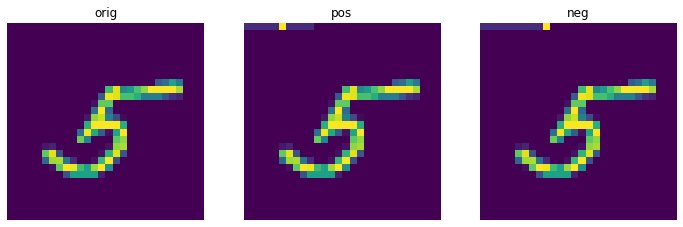

initial training...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:16<00:00, 30.51it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:34<00:00, 14.35it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:35<00:00, 14.17it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:35<00:00, 14.17it/s]


train accuracy after first training: 0.9690
train error after first training:    0.0310


hard pass 1: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 634.93it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 363.21it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 357.67it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 356.54it/s]


train accuracy after hard pass 1: 0.9557
train error after hard pass 1:    0.0443


hard pass 2: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 481.96it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 259.69it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 256.00it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 255.41it/s]


train accuracy after hard pass 2: 0.9644
train error after hard pass 2:    0.0356


hard pass 3: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 593.97it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 325.43it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 320.03it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 319.61it/s]


train accuracy after hard pass 3: 0.9677
train error after hard pass 3:    0.0323


hard pass 4: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 622.81it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 356.64it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 351.44it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 350.33it/s]


train accuracy after hard pass 4: 0.9694
train error after hard pass 4:    0.0306


hard pass 5: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 635.53it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 365.89it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 360.64it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 359.09it/s]


train accuracy after hard pass 5: 0.9692
train error after hard pass 5:    0.0308


hard pass 6: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 636.03it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 364.49it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 358.95it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 357.55it/s]


train accuracy after hard pass 6: 0.9712
train error after hard pass 6:    0.0288


hard pass 7: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 641.77it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 379.52it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 369.55it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 369.11it/s]


train accuracy after hard pass 7: 0.9733
train error after hard pass 7:    0.0267


hard pass 8: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 639.60it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 426.69it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 415.41it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 414.11it/s]


train accuracy after hard pass 8: 0.9742
train error after hard pass 8:    0.0258


hard pass 9: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 631.52it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 432.44it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 421.01it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 418.66it/s]


train accuracy after hard pass 9: 0.9755
train error after hard pass 9:    0.0245


hard pass 10: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 632.19it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 442.24it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 430.00it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 428.79it/s]


train accuracy after hard pass 10: 0.9761
train error after hard pass 10:    0.0239


hard pass 11: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 626.69it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 452.31it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 439.80it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 438.68it/s]


train accuracy after hard pass 11: 0.9797
train error after hard pass 11:    0.0203


hard pass 12: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 632.68it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 518.97it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 504.44it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 502.11it/s]


train accuracy after hard pass 12: 0.9790
train error after hard pass 12:    0.0210


hard pass 13: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 630.22it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 487.29it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 474.37it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:01<00:00, 472.31it/s]


train accuracy after hard pass 13: 0.9798
train error after hard pass 13:    0.0202


hard pass 14: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 622.79it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 519.87it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 504.30it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 503.36it/s]


train accuracy after hard pass 14: 0.9801
train error after hard pass 14:    0.0199


hard pass 15: re-training with hard negatives...
training Layer 1/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 635.78it/s]


training Layer 2/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 523.45it/s]


training Layer 3/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 508.23it/s]


training Layer 4/4...


training layer: 100%|██████████| 500/500 [00:00<00:00, 506.58it/s]


train accuracy after hard pass 15: 0.9816
train error after hard pass 15:    0.0184
final test accuracy:  0.9668
final test error:     0.0332


In [59]:
from tqdm import tqdm

input_images, labels = next(iter(train_loader))
input_images, labels = input_images.to('cuda'), labels.to('cuda')

positive_samples = add_labels(input_images, labels)
random_indices = derangement(input_images.size(0), device=labels.device)
shuffled_labels = labels[random_indices]
negative_samples = add_labels(input_images, shuffled_labels)

if torch.equal(shuffled_labels, labels):
    print("warning: shuffled labels are equal to original labels. shuffling might have failed.")
else:
    print("shuffling successful: shuffled labels are different from original labels.")

plot_imgs_side_by_side([input_images, positive_samples, negative_samples], ['orig', 'pos', 'neg'])

print("initial training...")
ff_net.forward_train(positive_samples, negative_samples)

train_predictions = ff_net.predict(input_images)
train_accuracy = train_predictions.eq(labels).float().mean().item()
train_error = 1.0 - train_accuracy
print(f"train accuracy after first training: {train_accuracy:.4f}")
print(f"train error after first training:    {train_error:.4f}")

num_hard_passes = 15

for hard_pass in range(1, num_hard_passes + 1):
    print("\n")
    incorrect_mask = train_predictions != labels
    if incorrect_mask.sum() == 0:
        print(f"no more incorrect predictions after pass {hard_pass - 1}. stopping early.")
        break

    incorrect_images = input_images[incorrect_mask]
    incorrect_pred_labels = train_predictions[incorrect_mask]

    hard_negative_samples = add_labels(incorrect_images, incorrect_pred_labels)
    correct_mask = ~incorrect_mask
    correct_images = input_images[correct_mask]
    correct_labels = labels[correct_mask]

    num_incorrect = incorrect_images.size(0)
    num_correct = correct_images.size(0)
    num_to_sample = min(num_correct, num_incorrect)

    sampled_indices = torch.randperm(num_correct, device=input_images.device)[:num_to_sample]
    sampled_correct_images = correct_images[sampled_indices]
    sampled_correct_labels = correct_labels[sampled_indices]

    hard_positive_samples = add_labels(sampled_correct_images, sampled_correct_labels)

    print(f"hard pass {hard_pass}: re-training with hard negatives...")

    ff_net.forward_train(hard_positive_samples, hard_negative_samples)

    train_predictions = ff_net.predict(input_images)
    train_accuracy = train_predictions.eq(labels).float().mean().item()
    train_error = 1.0 - train_accuracy
    print(f"train accuracy after hard pass {hard_pass}: {train_accuracy:.4f}")
    print(f"train error after hard pass {hard_pass}:    {train_error:.4f}")

test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.to('cuda'), test_labels.to('cuda')
test_predictions = ff_net.predict(test_images)
test_accuracy = test_predictions.eq(test_labels).float().mean().item()
test_error = 1.0 - test_accuracy
print(f"final test accuracy:  {test_accuracy:.4f}")
print(f"final test error:     {test_error:.4f}")